In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw11.ipynb")

# Homework 11: Spam/Ham Classification - Build Your Own Model

## Feature Engineering, Logistic Regression, Cross Validation
## Due Date: Thursday 8/5, 11:59 PM PDT

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In this homework, you will be building and improving on the concepts and functions that you implemented in Homework 10 to create your own classifier to distinguish spam emails from ham (non-spam) emails. We will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this assignment, you should feel comfortable with the following:

- Using `sklearn` libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
This is a **real world** dataset– the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these innapropriate emails, and wanted to give a warning at the beginning of the project so that you are made aware.

In [2]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Score Breakdown
Question | Points
--- | ---
1 | 6
2a | 4
2b | 2
3 | 3
4 | 15
Total | 30

## Setup and Recap

Here we will provide a summary of Homework 10 to remind you of how we cleaned the data, explored it, and implemented methods that are going to be useful for building your own model.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading and Cleaning Data

Remember that in email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the unlabeled test set contains 1000 unlabeled examples.

Run the following cell to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [4]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [5]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Feel free to explore the dataset above along with any specific spam and ham emails that interest you. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [6]:
# Fill any missing or NAN values
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


### Training/Validation Split

Recall that the training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We therefore split the training data into separate training and validation datsets. You will need this **validation data** to assess the performance of your classifier once you are finished training. 

As in Homework 10, we set the seed (random_state) to 42. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [7]:
# This creates a 90/10 train-validation split on our labeled data
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train = train.reset_index(drop = True)

### Feature Engineering

In order to train a logistic regression model, we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$. To address this, in Homework 10, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

For this homework, we have provided you with an implemented version of `words_in_texts`. Remember that the function outputs a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

In [8]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    import numpy as np
    indicator_array = 1 * np.array([texts.str.contains(word) for word in words]).T
    return indicator_array

Run the following cell to see how the function works on some dummy text.

In [9]:
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

### EDA and Basic Classification

In Homework 10, we proceeded to visualize the frequency of different words for both spam and ham emails, and used `words_in_texts(words, train['email'])` to directly to train a classifier. We also provided a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

We then built a model using the using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from `scikit-learn`.

Run the following cell to see the performance of a simple model using these words and the `train` dataframe.

In [10]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


### Evaluating Classifiers

In our models, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. In Homework 10, we calculated various metrics to lead us to consider more ways of evaluating a classifier, in addition to overall accuracy. Below is a reference to those concepts.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The two graphics below may help you understand precision and recall visually:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

# Moving Forward - Building Your Own Model

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Gradescope.

**Gradescope limits you to four submissions per day**. You will be able to see your accuracy on the entire test set when submitting to Gradescope.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 1, 2, and 3 should help guide you.

---

**Note:** *You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set.* Note, however, that you may overfit to your validation set if you try to optimize your validation accuracy too much. Alternatively, you can perform cross-validation on the entire training set.

---

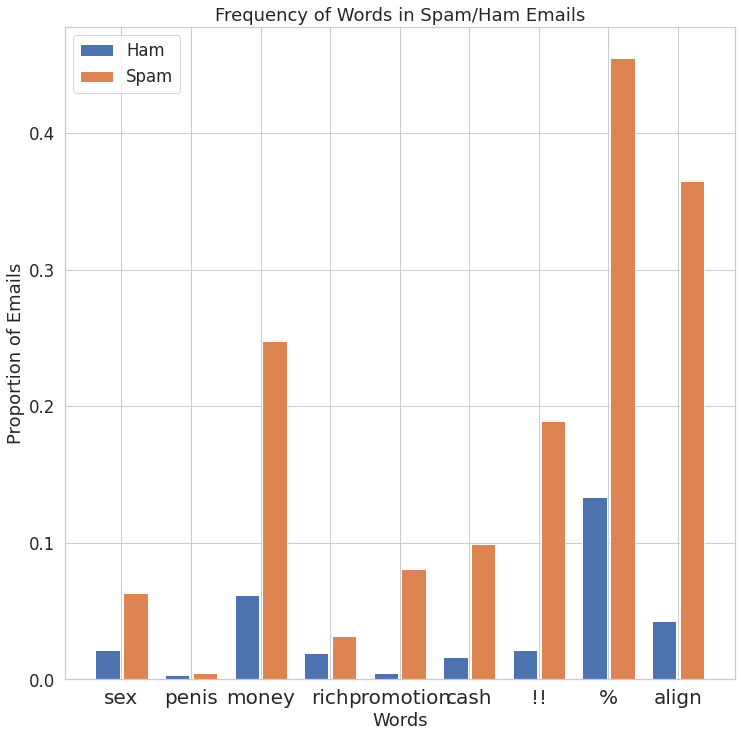

In [12]:
val = val.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
test_words = ['sex','penis','money','rich','promotion','cash','!!','%','align']
spam_stuff = val[val['spam'] == 1]['email']
non_spam = val[val['spam'] == 0]['email']
find_spam = words_in_texts(test_words, spam_stuff)
find_normal = words_in_texts(test_words, non_spam)

find_proportion_spam = np.sum(find_spam,axis=0)
find_proportion_normal = np.sum(find_normal,axis=0)
find_total_spam = len(spam_stuff)
find_total_normal = len(non_spam)


widthe = 0.35
widthy = 0.35
f, ax = plt.subplots(figsize=(12,12))
xe = np.arange(len(test_words))
plt.bar(xe - 0.2,find_proportion_normal/find_total_normal,width=0.35,label='Ham');
plt.bar(xe + 0.2,find_proportion_spam/find_total_spam,width=0.35,label='Spam');

plt.legend();
plt.xticks(xe, test_words)
plt.xlabel('Words');
plt.ylabel('Proportion of Emails');
plt.title('Frequency of Words in Spam/Ham Emails');
plt.xticks(size = 20)
plt.show();

In [13]:
new_no_spam = non_spam.str.split().values
words1 = {}
length_1 = len(new_no_spam)
for i in range(length_1):
    for k in new_no_spam[i]:
        if k in words1:
            words1[k] += 1
        else:
            words1[k] = 1
        
sorted_stuff2 = sorted(words1.items(), key=lambda item: item[1])
count_non = pd.DataFrame(sorted_stuff2)
count_non2 = count_non.rename(columns={0: "word", 1: "count_non"})
count4 = count_non2[count_non2["word"].isin(test_words)]
count4

,word,count_non
21607,penis,2
24992,rich,3
31878,cash,12
32325,sex,15
32551,%,18
33225,money,33


In [14]:
#@source https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
new_spam = spam_stuff.str.split().values
words= {}
length_2 = len(new_spam)
for i in range(length_2):
    for k in new_spam[i]:
        if k in words:
            words[k] += 1
        else:
            words[k] = 1
            
sorted_stuff = sorted(words.items(), key=lambda item: item[1])
count_spam = pd.DataFrame(sorted_stuff)
count_spam2 = count_spam.rename(columns={0: "word", 1: "count_spam"})
count3 = count_spam2[count_spam2["word"].isin(test_words)]
count3

,word,count_spam
7476,penis,1
18425,rich,3
19658,%,5
19997,sex,6
20396,promotion,7
21775,cash,30
22098,money,150


In [15]:
count_spam3 = count_spam2.sort_values(by='count_spam',ascending=False).iloc[:100,0:2]
count_spam3
count_non3 = count_non2.sort_values(by='count_non',ascending=False).iloc[:100,0:2]
count_non3

,word,count_non
33899,the,7321
33898,>,4561
33897,to,4227
33896,of,3498
33895,and,3437
...,...,...
33804,then,188
33803,email,187
33802,<font,185
33801,people,185


In [16]:
count_spam6 = count_spam2.sort_values(by='count_spam',ascending=False).iloc[400:800,0:2]
count_spam6
count_non6 = count_non2.sort_values(by='count_non',ascending=False).iloc[400:800,0:2]
count_non6

,word,count_non
33504,capital,53
33505,color:,53
33506,12,53
33496,4px,52
33495,build,52
...,...,...
33103,known,29
33105,community,29
33107,team,29
33108,fastest,29


In [17]:
result = pd.merge(count_spam3,count_non3,on='word',how="inner").head(50)
result["difference"] = result['count_spam'].sub(result['count_non'], axis = 0)
result2 = result.sort_values(by="difference",ascending=False)
result2.head(100)

,word,count_spam,count_non,difference
7,your,989,588,401
12,=,610,335,275
4,you,1421,1153,268
10,<td,799,544,255
28,<font,328,185,143
30,email,293,187,106
23,we,379,326,53
21,will,427,435,-8
46,people,164,185,-21
35,<table,237,265,-28


In [18]:
result = pd.merge(count_spam6,count_non6,on='word',how="inner").head(50)
result["difference"] = abs(result['count_spam'].sub(result['count_non'], axis = 0))
result2 = result.sort_values(by="difference",ascending=False)
result2.head(100)

,word,count_spam,count_non,difference
34,little,21,52,31
36,always,20,50,30
27,build,23,52,29
35,already,20,49,29
28,working,22,50,28
49,least,19,46,27
43,"""the",19,46,27
47,tell,19,45,26
42,begin,19,45,26
48,able,19,44,25


In [19]:
count_spam4 = count_spam2.sort_values(by='count_spam',ascending=False)
count_spam4
count_non4 = count_non2.sort_values(by='count_non',ascending=False)
count_non4

,word,count_non
33899,the,7321
33898,>,4561
33897,to,4227
33896,of,3498
33895,and,3437
...,...,...
11294,info@ekit.com,1
11293,imperative,1
11292,"tisdall*,",1
11291,*simon,1


In [20]:
result_map = pd.merge(count_spam4,count_non4,on='word',how="inner")
result_map

,word,count_spam,count_non
0,the,3085,7321
1,to,2362,4227
2,of,1971,3498
3,and,1799,3437
4,you,1421,1153
...,...,...,...
5817,eine,1,2
5818,freely,1,1
5819,privilege,1,2
5820,"privacy,",1,2


<!-- BEGIN QUESTION -->

### Question 1: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q1
manual: True
points: 6
-->

1.) I tried to find features based on the recommendations given. First I attempted the usage of more/better words.Checking through our emails, I first considered words with the highest count. This however was not helpful because many of the common english words are present in both sets, so we did have to conduct a different count of words. Then I merged our two dataframes, one with spam emails where 0 indicates it is not a spam email and 1 which indicates they are spam emails. I created a new column called difference which computes the difference between words used in spam and words used in ham. I noticed that spam words tend to have more undefined pattern and generated using symbols such as "!" and "<" whereas ham emails do not contain much of that when looking at the positive difference. My second experiement involving looking at emails and determing my selection of words I felt would not be in ham based on writing respectful emails. Words such as sex,money,!,etc raised more spam emails when graphing the proportions. The presence of certain words made a difference when considering the psychology of writing a respectful decent email compared to spam. After that, we just iterate through words, I took clusters of 100 using iloc, so for example the first 100 entries would be :100, 100:200, and so on. Doing this trial and error process we were able to deduce the difference in words between spam and ham and thus find better features for our model.

2.) Some of the features selected proved to be very useful such as the proportion of provactive terms in spam vs ham emails. The existence of symbols also helps to separate our spam from ham emails. However finding the count of words is not very useful because in the english language there are so many commonly used words that is present in both spam and ham. Using more words impacted the test accuracy, but we still have to consider overfitting our data, however adding more terms means better test accuracy. What didnt work for me was just using .head(), and looking at the text of spam and ham emails, through eyeballing it we gradually receive a better estimate, though it is not enough to warrant great accuracy, and often words are found in both. Finding the absolute difference is also a possiblity because if we only consider positive numbers we limit difference between spam and ham, there might be cases where ham have more than spam words.

3.) A few surprising aspects arose from my two experiments. First, spam emails have more symbols compared to ham though the difference is not that significant . The presence of more greedily and provactive used terms arise from spam emails compared to ham. How one determines them is very subjective and it would be beneficial to form an algorithm that captures this group very well.I found surprising however many funny terms positively impacted and increased our test accuracy. Symbols really impacted the accuracy of my model, adding a few resulted in greater accuracy when coupled with some provactive and insensitive terms.

<!-- END QUESTION -->



### Question 2: EDA

In the cell below, show a visualization that you used to select features for your model. 

Include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel free to create as many plots as you want in your process of feature selection, but select only one for the response cell below.

**You should not just produce an identical visualization to Question 3 in Homework 10.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

<!-- BEGIN QUESTION -->

#### Question 2a

Generate your visualization in the cell below.

<!--
BEGIN QUESTION
name: q2a
manual: True
format: image
points: 4
-->

In [21]:
#@source https://stackoverflow.com/questions/26778899/how-to-convert-matrix-to-pandas-data-frame

words_sample = ['sex','penis','money','rich','promotion','cash','!!','%','align',
        'font','<td','millionaire','god','fast','guarantee',
        'top','bank','refund','trust','scam','affordable',
        '=','your']

new_train2 = train
for i in words_sample:
    new_train2[i] = words_in_texts([i],train['email']) 

plot_correlation_words = new_train2[words_sample]
plot_correlation_words

,sex,penis,money,rich,promotion,cash,!!,%,align,font,...,fast,guarantee,top,bank,refund,trust,scam,affordable,=,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,1,1,1,...,1,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7509,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
7510,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


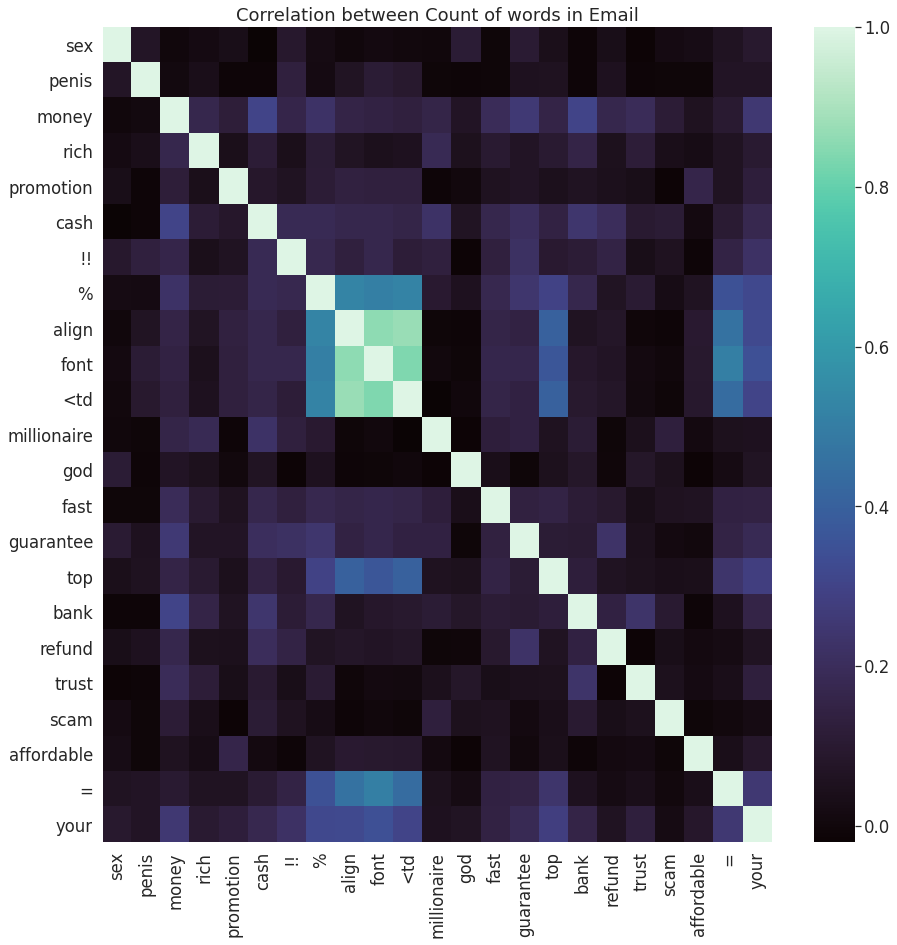

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(plot_correlation_words.corr(),cmap="mako");
plt.title("Correlation between Count of words in Email");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Question 2b

Write your commentary in the cell below.

<!--
BEGIN QUESTION
name: q2b
manual: True
points: 2
-->

The following as suggested is a heatmap plotting the correlation between the number/count of the word appearing. The following was chosen with a "mako" color because the defeat colors involves purple which is difficult to see the correlation at colors for example between 0.8 and 1 since the colors are too similiar. With the mako, we can better tell the difference between correlation of certain words. The plot itself shows the relationship between the following words. For example, there is a large correlation between "=" chaarcter and "font" suggesting these words are used together. Words with higher correlation can be used to better tell us which words in our following spam model will make our predictions more accurate.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3: ROC Curve

In most cases we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late, whereas a patient can just receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot a ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data. Refer to Lecture 20 to see how to plot an ROC curve.

**Hint**: You'll want to use the `.predict_proba` method for your classifier instead of `.predict` so you get probabilities instead of binary predictions.

<!--
BEGIN QUESTION
name: q3
manual: True
points: 3
-->

In [23]:
test_words_for = ['!','money','rich','cash','!!','%','align',
                  'height','url','body','<','drug','penis','boner',
                  'kiss','love','<html>','boob','bank','swag','>','=',
                  'font','<td','millionaire','god','fast','guarantee',
                  'top','CEO','bank','refund','trust','scam','affordable','=',
                  'your']
X_train2 = words_in_texts(test_words_for, train['email'])
Y_train2 = np.array(train['spam'])
X_test_creation = words_in_texts(test_words_for, test['email'])
model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train2,Y_train2)

LogisticRegression()

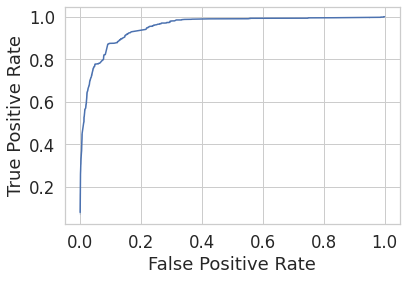

In [24]:
from sklearn.metrics import roc_curve

y = train['spam']
y_predict = model.predict_proba(X_train2)
y_predict2 = y_predict[:,1]
fpr, tpr, threshold = roc_curve(y,y_predict2)

fig = sns.lineplot(x=fpr,y=tpr);
fig.set_xlabel('False Positive Rate');
fig.set_ylabel('True Positive Rate');

<!-- END QUESTION -->

# Question 4: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to the "Homework 11 Test Predictions" assignment on Gradescope to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions`. **Please make sure you've saved your predictions to `test_predictions` as this is how part of your score for this question will be determined.**

**Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions.** For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

**Note: You may submit up to 4 times a day. If you have submitted 4 times on a day, you will need to wait until the next day for more submissions.**

Note that this question is graded on an absolute scale based on the accuracy your model achieves on the overall test set, and as such, your score does not depend on your ranking on Gradescope.

*The provided tests check that your predictions are in the correct format, but you must additionally submit to Gradescope to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q4
points: 3
-->

In [25]:
test_words_for = ['!','money','rich','cash','!!','%','align',
                  'height','url','body','<','drug','penis','boner',
                  'kiss','love','<html>','boob','bank','swag','>','=',
                  'font','<td','millionaire','god','fast','guarantee',
                  'top','CEO','bank','refund','trust','scam','affordable','=',
                  'your']
X_train2 = words_in_texts(test_words_for, train['email'])
Y_train2 = np.array(train['spam'])
X_test_creation = words_in_texts(test_words_for, test['email'])
model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train2,Y_train2)
test_predictions = model.predict(X_test_creation)

In [26]:
len(test_predictions)

1000

In [27]:
grader.check("q4")

q4 results: All test cases passed!

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Homework 10 Test Predictions" assignment on Gradescope to get credit for this question.**

Note that the file will appear in your DataHub, you must navigate to the `hw11` directory in your DataHub to download the file.

In [28]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Gradescope for scoring.')

Created a CSV file: submission_2021-08-04T21:44:10.csv.
You may now upload this CSV file to Gradescope for scoring.


## Congratulations! You have completed Homework 11!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [29]:
grader.check_all()

q4 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [30]:
# Save your notebook first, then run this cell to export your submission.
grader.export()